In [8]:
# importando bibliotecas necessárias
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import random
from tqdm import tqdm

In [2]:
# reprodutibilidade
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Constantes do projeto
BASE_PATH = './data/'
AUDIO_PATH = os.path.join(BASE_PATH, 'audio')
CSV_PATH = os.path.join(BASE_PATH, 'esc50.csv')

In [3]:
# Parâmetros para extração do Espectrograma de Mel
SAMPLE_RATE = 22050
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048
FIXED_LENGTH = 216

In [4]:
# ---  Carregamento dos Metadados ---
df = pd.read_csv(CSV_PATH)
df['full_path'] = df['filename'].apply(lambda fname: os.path.join(AUDIO_PATH, fname))
df.head()

,filename,fold,target,category,esc10,src_file,take,full_path
0,1-100032-A-0.wav,1,0,dog,True,100032,A,./data/audio/1-100032-A-0.wav
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,./data/audio/1-100038-A-14.wav
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,./data/audio/1-100210-A-36.wav
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,./data/audio/1-100210-B-36.wav
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,./data/audio/1-101296-A-19.wav


In [ ]:
# ---  Extração dos Espectrogramas de Mel ---

def get_mel_spectrogram(file_path):
    # Carrega o arquivo de áudio
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    
    mel_spec = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
    )

    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    
    if log_mel_spec.shape[1] < FIXED_LENGTH:
        pad_width = FIXED_LENGTH - log_mel_spec.shape[1]
        log_mel_spec = np.pad(log_mel_spec, ((0, 0), (0, pad_width)), mode='constant')
    else:
        log_mel_spec = log_mel_spec[:, :FIXED_LENGTH]
    
    log_mel_spec = (log_mel_spec - log_mel_spec.min()) / (log_mel_spec.max() - log_mel_spec.min())
        
    return log_mel_spec

X = []
y = []

print("Iniciando extração dos espectrogramas...")
for index, row in tqdm(df.iterrows(), total=len(df)):
    try:
        mel_spectrogram = get_mel_spectrogram(row['full_path'])
        X.append(mel_spectrogram)
        y.append(row['target']) # Usamos a coluna 'target' que já é numérica
    except Exception as e:
        print(f"Erro ao processar {row['full_path']}: {e}")

# Converte as listas para arrays NumPy
X = np.array(X)
y = np.array(y)

print(f"\nExtração concluída. Shape de X: {X.shape}, Shape de y: {y.shape}")

Iniciando extração dos espectrogramas...


100%|██████████| 2000/2000 [00:17<00:00, 114.66it/s]



Extração concluída. Shape de X: (2000, 128, 216), Shape de y: (2000,)


In [ ]:
X = X[..., np.newaxis]

num_classes = len(np.unique(y))
y_one_hot = tf.keras.utils.to_categorical(y, num_classes=num_classes)

train_indices = df['fold'].isin([1, 2, 3])
val_indices = df['fold'] == 4
test_indices = df['fold'] == 5

X_train, y_train = X[train_indices], y_one_hot[train_indices]
X_val, y_val = X[val_indices], y_one_hot[val_indices]
X_test, y_test = X[test_indices], y_one_hot[test_indices]

print(f"Shape de X_train: {X_train.shape}, Shape de y_train: {y_train.shape}")
print(f"Shape de X_val: {X_val.shape}, Shape de y_val: {y_val.shape}")
print(f"Shape de X_test: {X_test.shape}, Shape de y_test: {y_test.shape}")

Shape de X_train: (1200, 128, 216, 1), Shape de y_train: (1200, 50)
Shape de X_val: (400, 128, 216, 1), Shape de y_val: (400, 50)
Shape de X_test: (400, 128, 216, 1), Shape de y_test: (400, 50)


In [74]:
df_mapeamento = df.sort_values('target').drop_duplicates('target')
class_names = df_mapeamento['category'].tolist()
class_names

['dog',
 'rooster',
 'pig',
 'cow',
 'frog',
 'cat',
 'hen',
 'insects',
 'sheep',
 'crow',
 'rain',
 'sea_waves',
 'crackling_fire',
 'crickets',
 'chirping_birds',
 'water_drops',
 'wind',
 'pouring_water',
 'toilet_flush',
 'thunderstorm',
 'crying_baby',
 'sneezing',
 'clapping',
 'breathing',
 'coughing',
 'footsteps',
 'laughing',
 'brushing_teeth',
 'snoring',
 'drinking_sipping',
 'door_wood_knock',
 'mouse_click',
 'keyboard_typing',
 'door_wood_creaks',
 'can_opening',
 'washing_machine',
 'vacuum_cleaner',
 'clock_alarm',
 'clock_tick',
 'glass_breaking',
 'helicopter',
 'chainsaw',
 'siren',
 'car_horn',
 'engine',
 'train',
 'church_bells',
 'airplane',
 'fireworks',
 'hand_saw']

## Primeira CNN

In [ ]:
input_shape = X_train.shape[1:]

model_cnn_1 = models.Sequential([
    Input(shape=input_shape),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),


    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    # Camada de Saída
    layers.Dense(num_classes, activation='softmax')
], name='CNN_Model_1')

model_cnn_1.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn_1.summary()

Model: "CNN_Model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 128, 216, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128, 216, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 64, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 108, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64, 108, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 32, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 54, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 16, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 55296)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     7,078,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 50)             │         6,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,178,034 (27.38 MB)

 Trainable params: 7,177,586 (27.38 MB)

 Non-trainable params: 448 (1.75 KB)

In [76]:
checkpoint_callback = ModelCheckpoint(
    filepath='modelos/melhor_cnn_1.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_callback = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    verbose=1
)

history_cnn_1 = model_cnn_1.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_callback, early_stopping_callback]
)

model_cnn_1.load_weights('modelos/melhor_cnn_1.keras')

Epoch 1/100


2025-07-20 14:56:37.313548: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.1846 - loss: 3.9571

2025-07-20 14:57:08.454292: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Epoch 1: val_accuracy improved from -inf to 0.01500, saving model to modelos/melhor_cnn_1.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 841ms/step - accuracy: 0.1858 - loss: 3.9421 - val_accuracy: 0.0150 - val_loss: 10.1514
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.3364 - loss: 2.5453
Epoch 2: val_accuracy did not improve from 0.01500
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 823ms/step - accuracy: 0.3368 - loss: 2.5430 - val_accuracy: 0.0150 - val_loss: 11.4645
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.4400 - loss: 2.0415
Epoch 3: val_accuracy improved from 0.01500 to 0.02750, saving model to modelos/melhor_cnn_1.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 834ms/step - accuracy: 0.4403 - loss: 2.0397 - val_accuracy: 0.0275 - val_loss: 10.0487
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.5657 - loss: 1.4668
Epoch 4: val_accuracy improved from 0.02750 to 0.03500, saving model to modelos/melhor_cnn_1.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 839ms

In [ ]:
def plotar_historico_e_avaliar(history, model, model_name, x_test, y_test, class_names):
    """
    Avalia um modelo, gera gráficos de histórico, relatório de classificação e matriz de confusão.

    Args:
        history (tf.keras.callbacks.History): Objeto retornado pelo método `model.fit()`.
        model (tf.keras.Model): O modelo Keras treinado.
        model_name (str): Nome do modelo para ser usado nos títulos.
        x_test (np.ndarray): Dados de teste (features).
        y_test (np.ndarray): Rótulos de teste (labels), em formato one-hot.
        class_names (list): Lista com os nomes (string) de cada classe.

    Returns:
        tuple: Uma 3-upla contendo:
               - pd.DataFrame: O relatório de classificação.
               - plt.Figure: A figura com os gráficos de histórico de treino/validação.
               - plt.Figure: A figura com a matriz de confusão.
    """
    print(f"--- Gerando análise completa para o modelo '{model_name}' ---")
    num_classes = len(class_names)

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"\nAcurácia no conjunto de teste: {test_acc:.4f}")
    print(f"Perda (loss) no conjunto de teste: {test_loss:.4f}\n")


    y_pred_probs = model.predict(x_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    
    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
    dataframe_report = pd.DataFrame(report_dict).transpose()
    print("Relatório de Classificação gerado.")

    
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs_range = range(len(acc))

    fig_hist, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig_hist.suptitle(f'Histórico de Treinamento - {model_name}', fontsize=16)

    # Gráfico de Acurácia
    ax1.plot(epochs_range, acc, label='Acurácia de Treino', color='dodgerblue', marker='o', markersize=4, linestyle='-')
    ax1.plot(epochs_range, val_acc, label='Acurácia de Validação', color='darkorange', marker='s', markersize=4, linestyle='--')
    ax1.axhline(y=1/num_classes, color='gray', linestyle=':', label=f'Acurácia Aleatória ({100/num_classes:.1f}%)')
    ax1.axhline(y=0.813, color='green', linestyle=':', label='Acurácia Humana (81.3%)')
    ax1.legend(loc='lower right')
    ax1.set_title('Acurácia por Época')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Acurácia')
    ax1.grid(True)

    # Gráfico de Perda
    ax2.plot(epochs_range, loss, label='Perda de Treino', color='dodgerblue', marker='o', markersize=4, linestyle='-')
    ax2.plot(epochs_range, val_loss, label='Perda de Validação', color='darkorange', marker='s', markersize=4, linestyle='--')
    ax2.legend(loc='upper right')
    ax2.set_title('Perda (Loss) por Época')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Perda')
    ax2.grid(True)
    
    fig_hist.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    print("Gráficos de histórico gerados.")

    conf_matrix_data = confusion_matrix(y_true, y_pred)
    fig_cm, ax_cm = plt.subplots(figsize=(10, 10))
    sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=ax_cm, cbar=False)
    ax_cm.set_title(f'Matriz de Confusão - {model_name}', fontsize=16)
    ax_cm.set_ylabel('Classe Verdadeira', fontsize=12)
    ax_cm.set_xlabel('Classe Prevista', fontsize=12)
    fig_cm.tight_layout()
    print("Matriz de confusão gerada.")

    fig_hist.savefig(f"imgs/historico_{model_name}.png", dpi=300)
    fig_cm.savefig(f"imgs/matriz_confusao_{model_name}.png", dpi=300)

    return dataframe_report, fig_hist, fig_cm

--- Gerando análise completa para o modelo 'CNN Modelo 1' ---


2025-07-20 15:21:46.216702: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Acurácia no conjunto de teste: 0.4250
Perda (loss) no conjunto de teste: 3.2619

Relatório de Classificação gerado.
Gráficos de histórico gerados.
Matriz de confusão gerada.


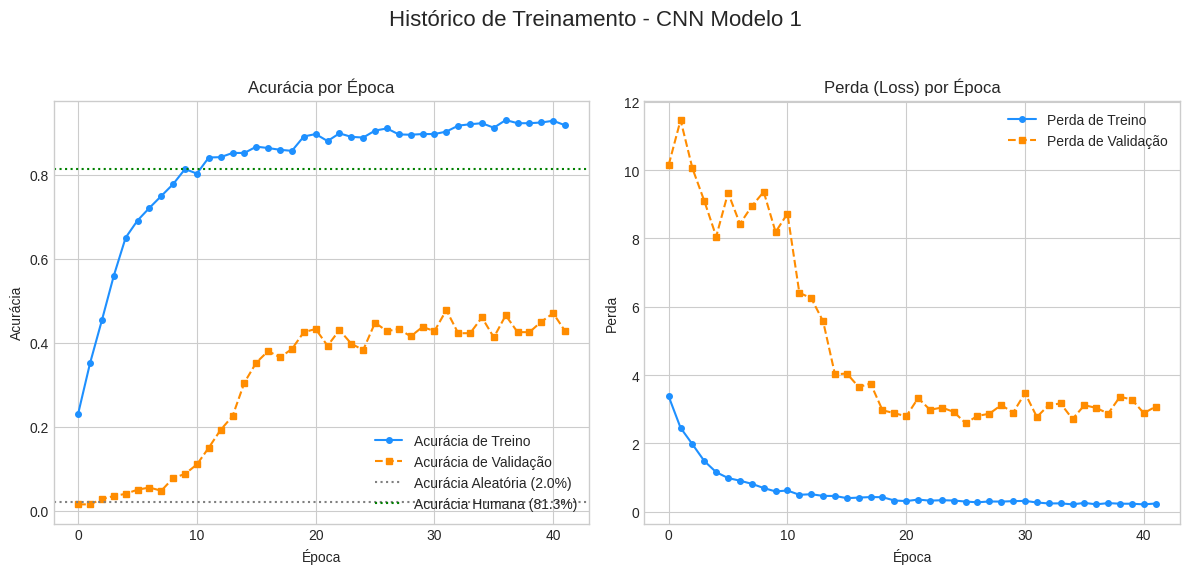

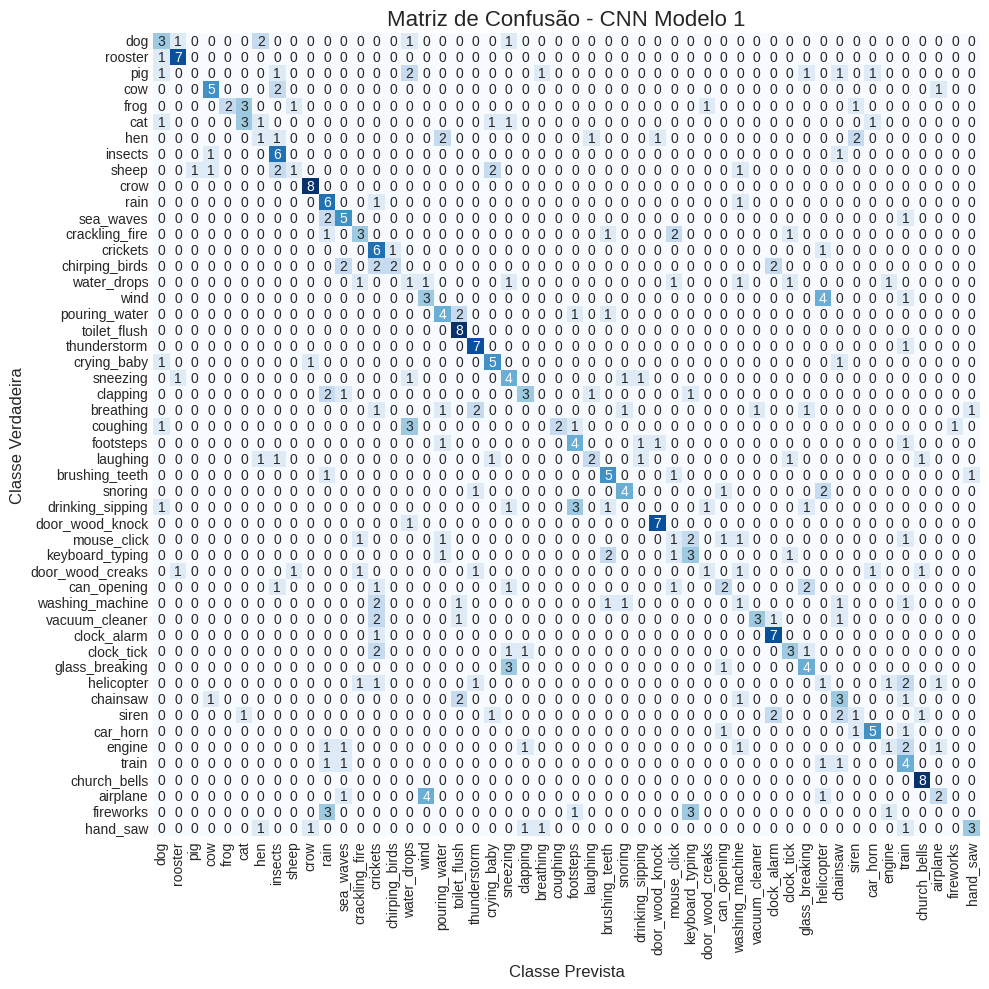

In [78]:
report_cnn_1, historico_cnn_1, matriz_conf_cnn_1 = plotar_historico_e_avaliar(history_cnn_1, model_cnn_1, 'CNN Modelo 1', X_test, y_test, class_names=class_names)

In [79]:
report_cnn_1

,precision,recall,f1-score,support
dog,0.333333,0.375,0.352941,8.000
rooster,0.700000,0.875,0.777778,8.000
pig,0.000000,0.000,0.000000,8.000
cow,0.625000,0.625,0.625000,8.000
frog,1.000000,0.250,0.400000,8.000
cat,0.428571,0.375,0.400000,8.000
hen,0.166667,0.125,0.142857,8.000
insects,0.428571,0.750,0.545455,8.000
sheep,0.333333,0.125,0.181818,8.000
crow,0.800000,1.000,0.888889,8.000


## Segunda CNN

In [80]:
# divisão entre treino e teste
X_train, X_test, y_train_labels, y_test_labels = train_test_split(
    X, 
    y, 
    test_size=0.20, 
    random_state=SEED, 
    stratify=y 
)

num_classes = 50
y_train = tf.keras.utils.to_categorical(y_train_labels, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test_labels, num_classes=num_classes)

In [ ]:
model_cnn_2 = models.Sequential(name="cnn_2")
model_cnn_2.add(Input(shape=input_shape))

# Bloco 1
model_cnn_2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_cnn_2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(MaxPooling2D(pool_size=(2, 2)))

# Bloco 2
model_cnn_2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_cnn_2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(MaxPooling2D(pool_size=(2, 2)))

# Bloco 3
model_cnn_2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_cnn_2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(MaxPooling2D(pool_size=(2, 2)))

# Camadas de Classificação
model_cnn_2.add(layers.Flatten())
model_cnn_2.add(layers.Dense(256, activation='relu'))
model_cnn_2.add(layers.Dropout(0.5))
model_cnn_2.add(layers.Dense(num_classes, activation='softmax'))

In [89]:
model_cnn_2.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_cnn_2.summary()

Model: "cnn_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 128, 216, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 128, 216, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 128, 216, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 64, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 64, 108, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 64, 108, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 64, 108, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 32, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 32, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 32, 54, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 32, 54, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 16, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 55296)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │    14,156,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,456,210 (55.15 MB)

 Trainable params: 14,455,762 (55.14 MB)

 Non-trainable params: 448 (1.75 KB)

In [90]:
cnn_2_callback = ModelCheckpoint(
    filepath='modelos/melhor_cnn_2.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_callback = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    verbose=1
)

history_cnn_2 = model_cnn_2.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[cnn_2_callback, early_stopping_callback]
)

model_cnn_2.load_weights('modelos/melhor_cnn_2.keras')

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0330 - loss: 5.2624

2025-07-20 15:31:48.792815: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Epoch 1: val_accuracy improved from -inf to 0.02000, saving model to modelos/melhor_cnn_2.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.0334 - loss: 5.2483 - val_accuracy: 0.0200 - val_loss: 3.9860
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1597 - loss: 3.2971
Epoch 2: val_accuracy did not improve from 0.02000
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.1597 - loss: 3.2968 - val_accuracy: 0.0200 - val_loss: 4.2065
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2527 - loss: 2.8251
Epoch 3: val_accuracy did not improve from 0.02000
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.2527 - loss: 2.8249 - val_accuracy: 0.0200 - val_loss: 4.4668
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3695 - loss: 2.3835
Epoch 4: val_accuracy did not improve from 0.02000
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.3693 - loss: 2.3832 - val_accuracy: 0.0200 - val_loss: 4.6384
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━

--- Gerando análise completa para o modelo 'CNN Modelo 2' ---


2025-07-20 17:00:52.234904: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Acurácia no conjunto de teste: 0.5625
Perda (loss) no conjunto de teste: 1.8821

Relatório de Classificação gerado.
Gráficos de histórico gerados.
Matriz de confusão gerada.


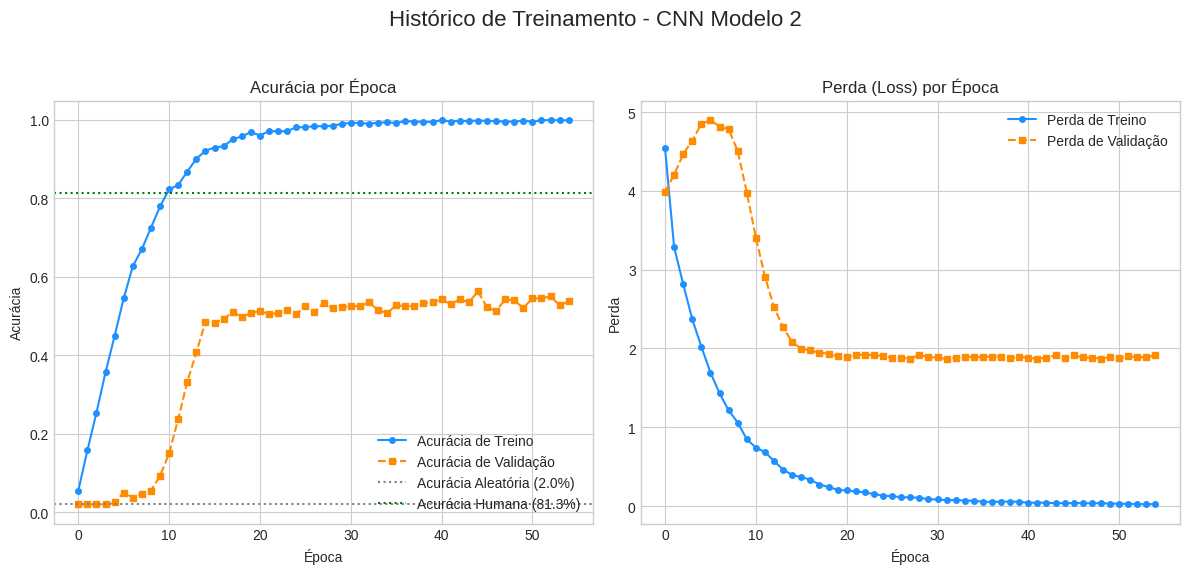

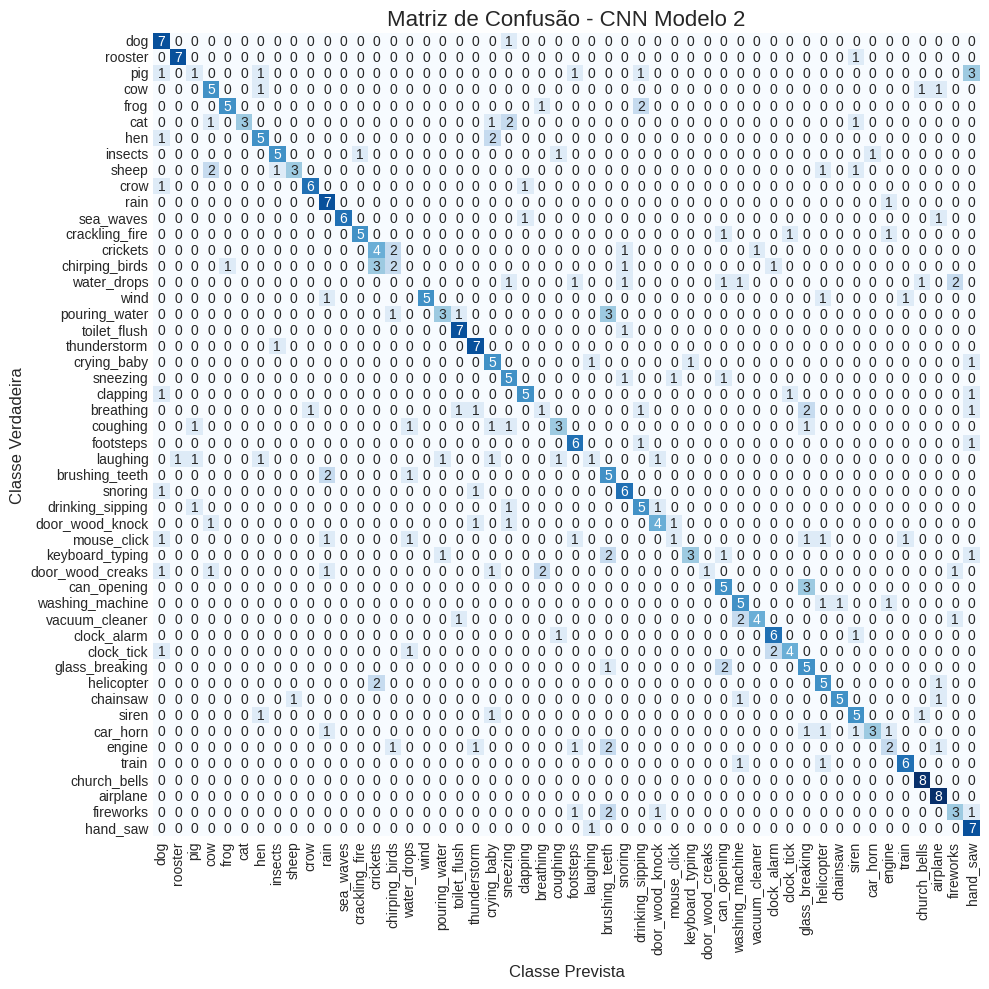

In [91]:
report_cnn_2, historico_cnn_2, matriz_conf_cnn_2 = plotar_historico_e_avaliar(history_cnn_2, model_cnn_2, 'CNN Modelo 2', X_test, y_test, class_names=class_names)

In [92]:
report_cnn_2

,precision,recall,f1-score,support
dog,0.466667,0.8750,0.608696,8.0000
rooster,0.875000,0.8750,0.875000,8.0000
pig,0.250000,0.1250,0.166667,8.0000
cow,0.500000,0.6250,0.555556,8.0000
frog,0.833333,0.6250,0.714286,8.0000
cat,1.000000,0.3750,0.545455,8.0000
hen,0.555556,0.6250,0.588235,8.0000
insects,0.714286,0.6250,0.666667,8.0000
sheep,0.750000,0.3750,0.500000,8.0000
crow,0.857143,0.7500,0.800000,8.0000


## CRNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Reshape, GRU, Bidirectional, Dense, Dropout

input_shape = (128, 216, 1)
num_classes = 50

model_cnn_gru = models.Sequential([
    Input(shape=input_shape),


    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),


    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),


    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Reshape(target_shape=(27, 2048)),
    
    Bidirectional(GRU(128, return_sequences=False)),
    Dropout(0.3),

    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
], name="cnn_gru")



model_cnn_gru.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn_gru.summary()

Model: "cnn_gru"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_122 (Conv2D)             │ (None, 128, 216, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_123 (Conv2D)             │ (None, 128, 216, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 128, 216, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 64, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 64, 108, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_125 (Conv2D)             │ (None, 64, 108, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 64, 108, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 32, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_126 (Conv2D)             │ (None, 32, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_127 (Conv2D)             │ (None, 32, 54, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 32, 54, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 16, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 27, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │     1,672,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,038,674 (7.78 MB)

 Trainable params: 2,038,226 (7.78 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
gru_checkpoint = ModelCheckpoint(
    filepath='modelos/melhor_gru.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_callback = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    verbose=1
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

gru_history = model_cnn_gru.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[gru_checkpoint, early_stopping_callback, reduce_lr_callback]
)

model_cnn_gru.load_weights('modelos/melhor_gru.keras')

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0503 - loss: 3.8287

2025-07-20 18:57:41.549473: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Epoch 1: val_accuracy improved from -inf to 0.02000, saving model to modelos/melhor_gru.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.0505 - loss: 3.8269 - val_accuracy: 0.0200 - val_loss: 4.4569 - learning_rate: 0.0010
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1019 - loss: 3.5100
Epoch 2: val_accuracy did not improve from 0.02000
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.1020 - loss: 3.5082 - val_accuracy: 0.0200 - val_loss: 4.5387 - learning_rate: 0.0010
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1602 - loss: 3.2399
Epoch 3: val_accuracy did not improve from 0.02000
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.1603 - loss: 3.2386 - val_accuracy: 0.0200 - val_loss: 5.0535 - learning_rate: 0.0010
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2011 - loss: 2.9671
Epoch 4: val_accuracy improved from 0.02000 to 0.02250, saving model to modelos/melhor_gru.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/ste

--- Gerando análise completa para o modelo 'GRU' ---


2025-07-20 19:38:56.435288: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Acurácia no conjunto de teste: 0.5750
Perda (loss) no conjunto de teste: 1.5700

Relatório de Classificação gerado.
Gráficos de histórico gerados.
Matriz de confusão gerada.


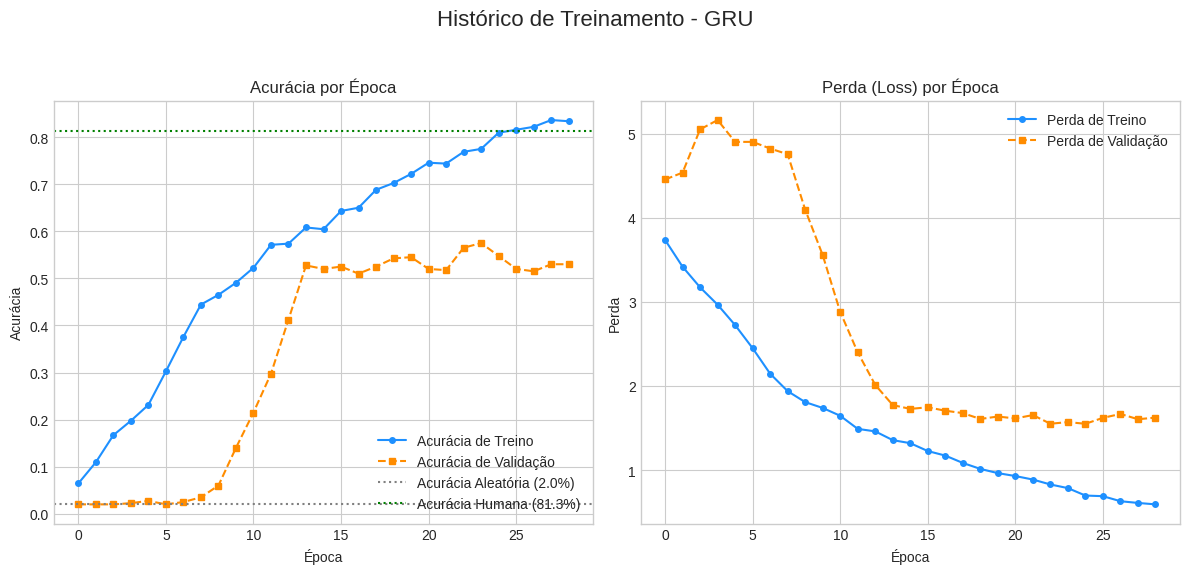

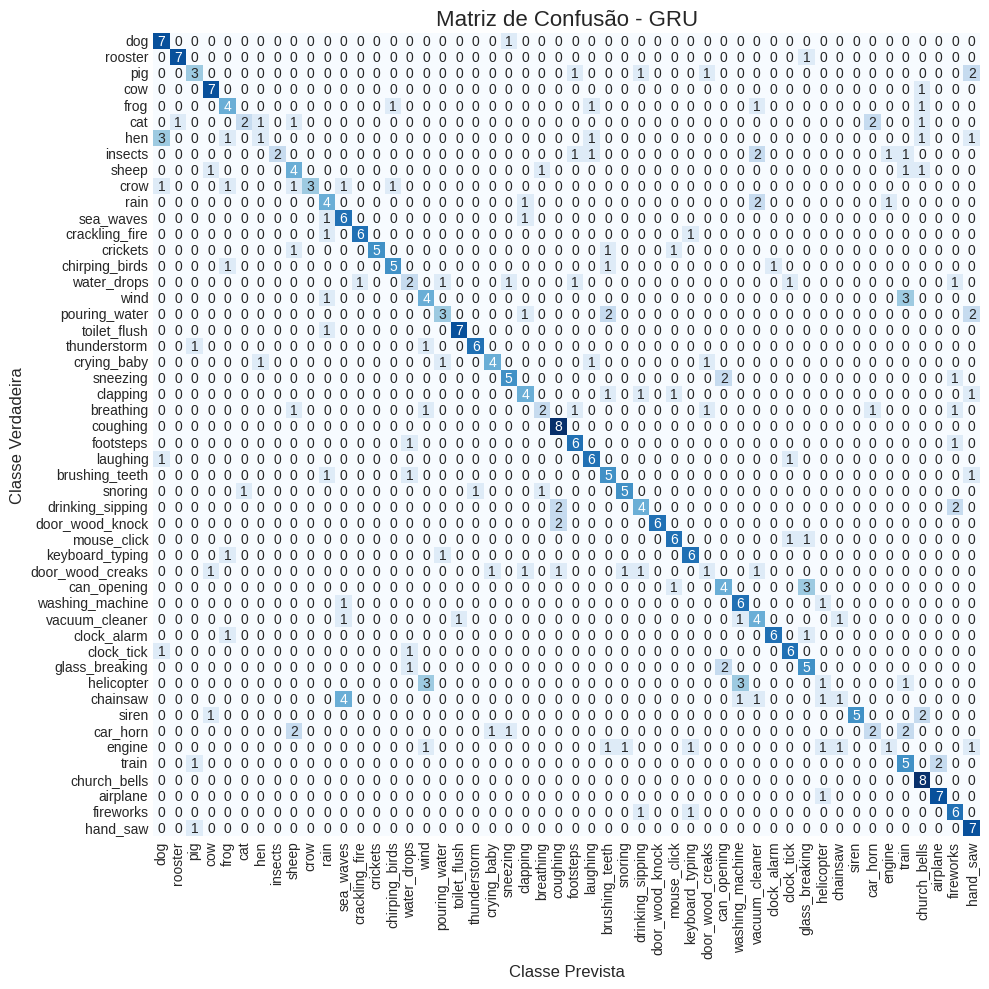

In [134]:
report_gru, historico_gru, matriz_conf_gru = plotar_historico_e_avaliar(gru_history, model_cnn_gru, 'GRU', X_test, y_test, class_names=class_names)

## Transfer learning com Transformador

In [5]:
from datasets import Dataset, ClassLabel
import evaluate
from transformers import (
    AutoFeatureExtractor,
    AutoModelForAudioClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

model_id = "MIT/ast-finetuned-audioset-10-10-0.4593"

/home/mateus/miniconda3/envs/ap_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
dataset = Dataset.from_pandas(df)

feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)
target_sr = feature_extractor.sampling_rate

dataset = dataset.cast_column("target", ClassLabel(num_classes=50))
dataset = dataset.rename_column("target", "labels")


def preprocess_function(examples):
    audio_arrays = [librosa.load(path, sr=target_sr)[0] for path in examples["full_path"]]
    inputs = feature_extractor(audio_arrays, sampling_rate=target_sr, padding=True)
    inputs["labels"] = examples["labels"]
    return inputs


dataset = dataset.map(preprocess_function, remove_columns=dataset.column_names, batched=True)

split = dataset.train_test_split(test_size=0.2, stratify_by_column="labels", seed=42)
train_dataset = split["train"]
test_dataset = split["test"]

Map: 100%|██████████| 2000/2000 [00:10<00:00, 190.68 examples/s]


In [9]:
model = AutoModelForAudioClassification.from_pretrained(
    model_id,
    num_labels=50,
    ignore_mismatched_sizes=True
)

accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1_score(labels, preds, average="macro")
    }

training_args = TrainingArguments(
    output_dir="./modelos/ast",
    eval_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    report_to="none"
)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([50]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([50, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

/tmp/ipykernel_4784/1414024334.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/mateus/miniconda3/envs/ap_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Accuracy,F1 Macro
100,1.949400,0.656788,0.890000,0.878545
200,0.466400,0.302771,0.932500,0.933061
300,0.110900,0.186075,0.932500,0.932407
400,0.066900,0.228367,0.937500,0.936659
500,0.018000,0.191760,0.952500,0.952570
600,0.018800,0.161407,0.950000,0.949944
700,0.007900,0.165346,0.960000,0.959483
800,0.007400,0.132120,0.960000,0.960231
900,0.001900,0.137356,0.960000,0.959763
1000,0.001000,0.147285,0.965000,0.964799


/home/mateus/miniconda3/envs/ap_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/mateus/miniconda3/envs/ap_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/mateus/miniconda3/envs/ap_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/mateus/miniconda3/envs/ap_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/mateus

TrainOutput(global_step=1300, training_loss=0.20389804150049504, metrics={'train_runtime': 22460.3628, 'train_samples_per_second': 0.712, 'train_steps_per_second': 0.089, 'total_flos': 7.052434341888e+17, 'train_loss': 0.20389804150049504, 'epoch': 6.5})

In [ ]:
# matriz de confusão
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

cm = confusion_matrix(y_true, y_pred)

/home/mateus/miniconda3/envs/ap_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [19]:
names = df.sort_values("target").drop_duplicates("target")['category'].tolist()

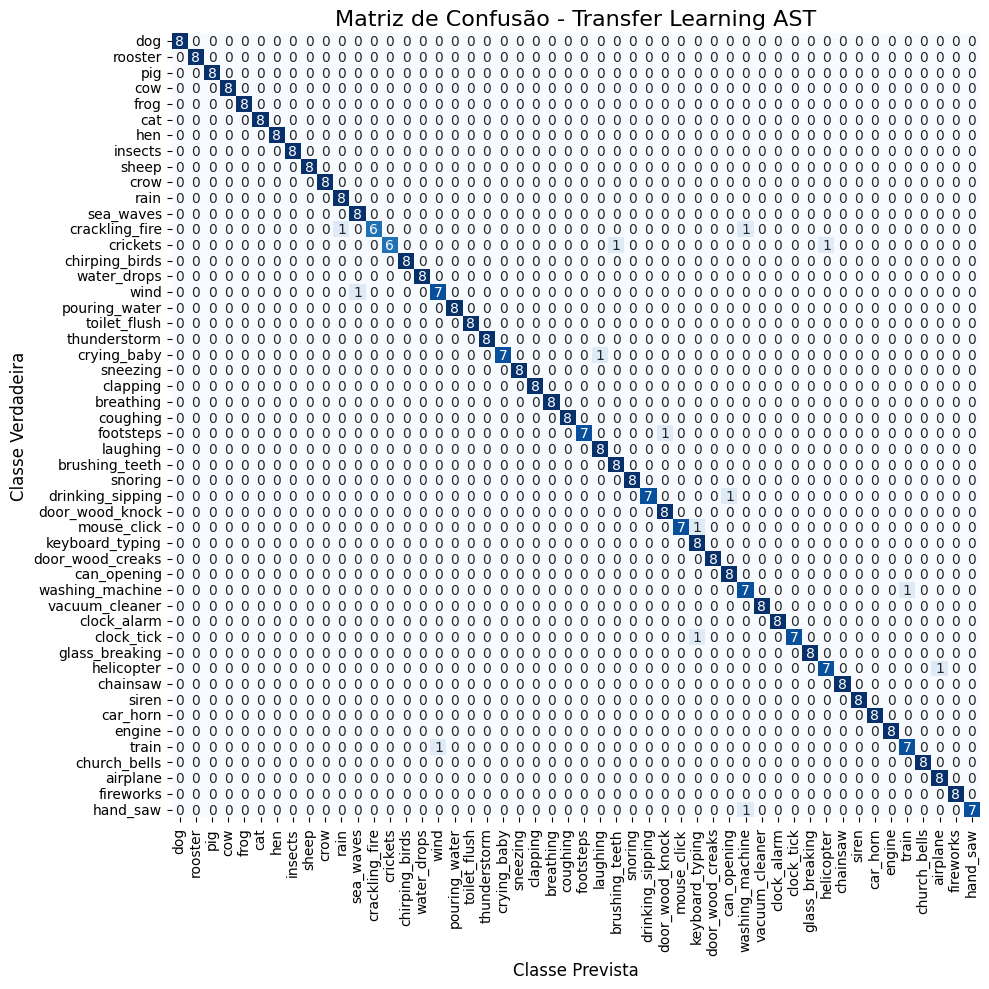

In [20]:
fig_cm, ax_cm = plt.subplots(figsize=(10, 10)) # Tamanho grande para 50 classes
# sem barra de cores
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=names, yticklabels=names, ax=ax_cm, cbar=False)
ax_cm.set_title(f'Matriz de Confusão - Transfer Learning AST', fontsize=16)
ax_cm.set_ylabel('Classe Verdadeira', fontsize=12)
ax_cm.set_xlabel('Classe Prevista', fontsize=12)
fig_cm.tight_layout()
fig_cm.savefig(f"imgs/matriz_confusao_transfer_learning.png", dpi=300)


In [21]:
report_dict = classification_report(y_true, y_pred, target_names=names, output_dict=True, zero_division=0)
dataframe_report = pd.DataFrame(report_dict).transpose()
dataframe_report

,precision,recall,f1-score,support
dog,1.000000,1.000,1.000000,8.000
rooster,1.000000,1.000,1.000000,8.000
pig,1.000000,1.000,1.000000,8.000
cow,1.000000,1.000,1.000000,8.000
frog,1.000000,1.000,1.000000,8.000
cat,1.000000,1.000,1.000000,8.000
hen,1.000000,1.000,1.000000,8.000
insects,1.000000,1.000,1.000000,8.000
sheep,1.000000,1.000,1.000000,8.000
crow,1.000000,1.000,1.000000,8.000


In [48]:
log_history = pd.DataFrame(trainer.state.log_history)
log_history = log_history[['loss', 'eval_loss', 'epoch', 'eval_accuracy']]
log_history = log_history.ffill().loc[[i for i in range(len(log_history)) if i % 2 == 1]]
log_history

,loss,eval_loss,epoch,eval_accuracy
1,1.9494,0.656788,0.5,0.8900
3,0.4664,0.302771,1.0,0.9325
5,0.1109,0.186075,1.5,0.9325
7,0.0669,0.228367,2.0,0.9375
9,0.0180,0.191760,2.5,0.9525
11,0.0188,0.161407,3.0,0.9500
13,0.0079,0.165346,3.5,0.9600
15,0.0074,0.132120,4.0,0.9600
17,0.0019,0.137356,4.5,0.9600
19,0.0010,0.147285,5.0,0.9650


In [54]:
history_dict = log_history.to_dict()

In [55]:
epochs = [v for _, v in sorted(history_dict['epoch'].items())]
train_loss = [v for k, v in sorted(history_dict['loss'].items())]
val_loss = [v for k, v in sorted(history_dict['eval_loss'].items())]
val_acc = [v for k, v in sorted(history_dict['eval_accuracy'].items())]

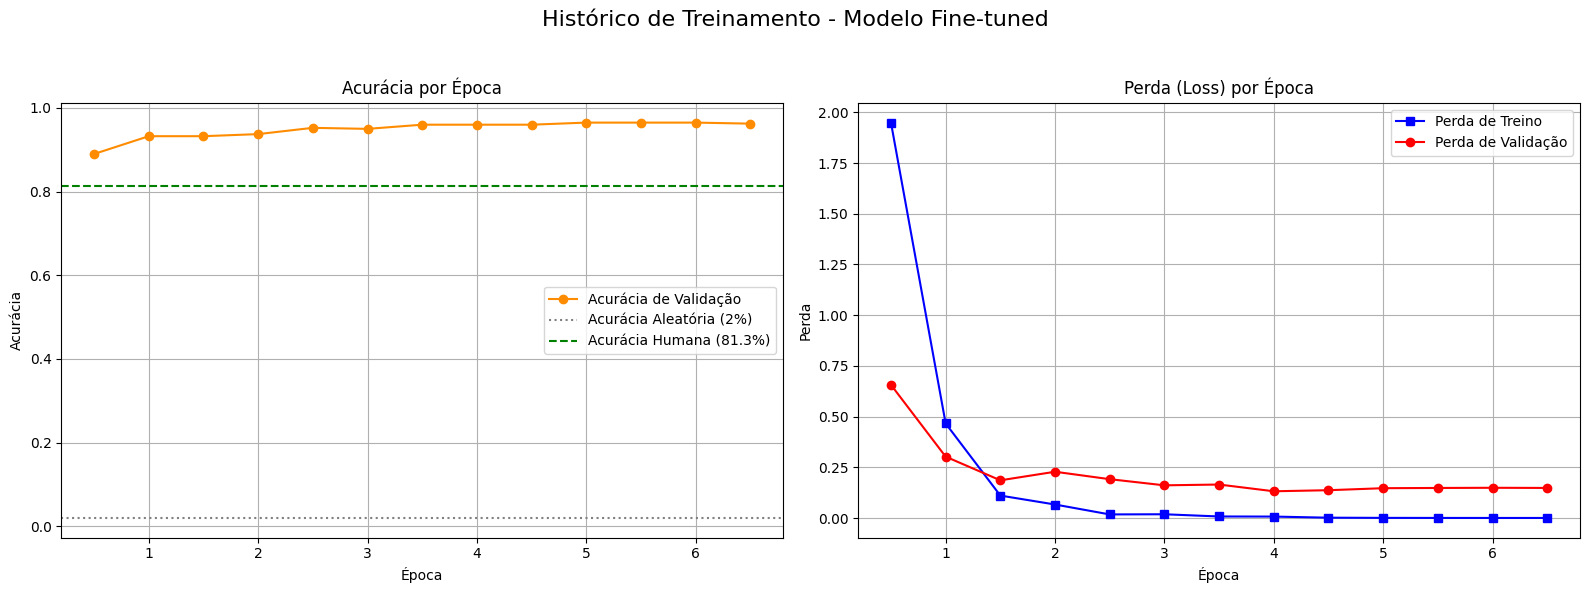

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Histórico de Treinamento - Modelo Fine-tuned", fontsize=16)

# acc
ax1.plot(epochs, val_acc, marker='o', label='Acurácia de Validação', color='darkorange')
ax1.axhline(y=0.02, color='gray', linestyle=':', label='Acurácia Aleatória (2%)')
ax1.axhline(y=0.813, color='green', linestyle='--', label='Acurácia Humana (81.3%)')
ax1.set_xlabel('Época')
ax1.set_ylabel('Acurácia')
ax1.set_title('Acurácia por Época')
ax1.legend()
ax1.grid(True)

# loss
ax2.plot(epochs, train_loss, marker='s', label='Perda de Treino', color='blue')
ax2.plot(epochs, val_loss, marker='o', label='Perda de Validação', color='red')
ax2.set_xlabel('Época')
ax2.set_ylabel('Perda')
ax2.set_title('Perda (Loss) por Época')
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
fig.savefig("imgs/historico_transfer_learning.png", dpi=300)